# 43E-modeling-ARIMA-product-cycling

This notebook is an ARIMA attempt by determining that each iPhone model goes through the same product life cycle. Since every iPhone model will have a first occurrence of claims (we essentially treat it as week 1 of claims data) happen during their product life cycle and the same end data point as 2/6/23, then we can append each of the iPhone models together by having their product life cycle dates match up to create a larger dataset to apply the ARIMA model. The model uses iPhone 11-14 data to create the product cycle appending.

Since we do not have each iPhone model's starting product life cycle as weeks since released as 0, we used ARIMA to forecast backwards in time to try to create an appropriate beginning product life cycle for the necessary iPhone models before we can append the product life cycles together.

Order of appending the iPhone 11-14 product life cycles (starting from left to right):
- iPhone 11 - forecasted backwards in time using ARIMA - appended product life cycle is going backwards over time to have its first data point be 2/6/23 and last data point be the approximated 1st week of claims data
- iPhone 12 - forecasted backwards in time using ARIMA - appended product life cycle is going forwards over time as the first value is the approximated 1st week of claims data while the last claims value represents 2/6/23
- iPhone 13 - beginning of product life cycle was given - appended product life cycle is going backwards over time to have its first data point be 2/6/23 and last data point be its 1st week of claims data.
- iPhone 14 - beginning of product life cycle was given - appended product life cycle is going forwards over time as the first value is the 1st week of claims data.

Once these product life cycles are appened, we can use the model to predict what are iPhone 14 claims values for the month of March 2023.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import ADFTest
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score

In [2]:
#Constants/globals
os.chdir('/data/p_dsi/teams2023/team9/')
os.getcwd()

In [3]:
#load the data
data = pd.read_csv("Asurion_clean_data_feature_set.csv")
display(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   phone model       11684 non-null  object
 1   phone size        11684 non-null  object
 2   phone color       11684 non-null  object
 3   claim             11684 non-null  int64 
 4   weeks_monday      11684 non-null  object
 5   month             11684 non-null  object
 6   year              11684 non-null  int64 
 7   season            11684 non-null  object
 8   quarter           11684 non-null  object
 9   Holidays_Boolean  11684 non-null  bool  
 10  company           11684 non-null  object
 11  model_group       11684 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 1015.6+ KB


None

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group
0,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
1,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
2,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
3,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
4,apple iphone 11,128gb,white,91,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
5,apple iphone 11,128gb,yellow,5,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
6,apple iphone 11,256gb,black,24,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
7,apple iphone 11,256gb,green,3,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
8,apple iphone 11,256gb,purple,7,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
9,apple iphone 11,256gb,red,9,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11


In [4]:
group_model = data.groupby('model_group')
group_model.first()

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company
model_group,,,,,,,,,,,
iphone 11,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple
iphone 12,apple iphone 12,128gb,black,68,2022-01-24,January,2022,winter,Q1,False,apple
iphone 13,apple iphone 13,128gb,midnight,11,2022-01-24,January,2022,winter,Q1,False,apple
iphone 14,apple iphone 14,128gb,black,7,2022-11-14,November,2022,autumn,Q4,False,apple
iphone se,apple iphone se,128gb,gray,1,2022-01-24,January,2022,winter,Q1,False,apple
iphone x,apple iphone x,256gb,gray,62,2022-01-24,January,2022,winter,Q1,False,apple


Text(0.5, 1.0, 'iPhone 14')

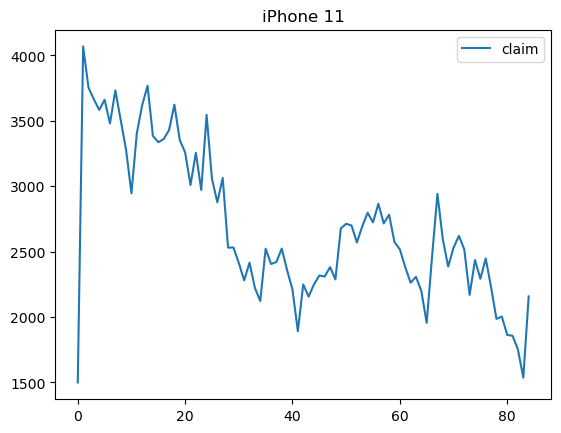

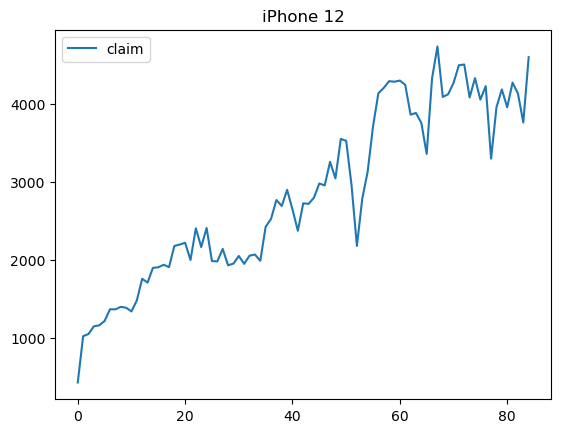

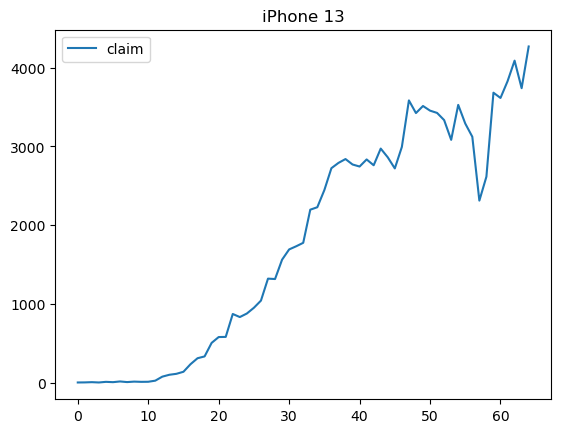

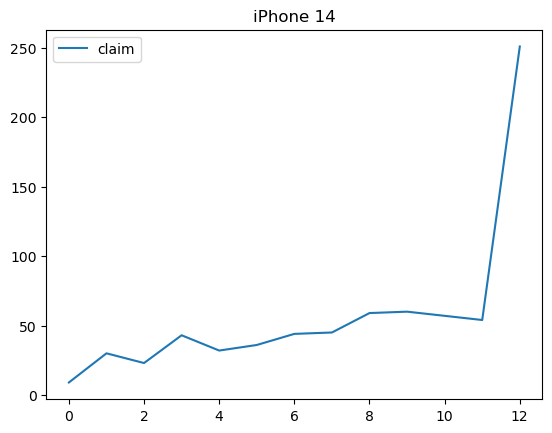

In [5]:
# As discussed with professor, removing the last row of aggregate data since it looks like they're incomplete data, this is
# applied to all models 

iphone11 = data[data["model_group"] == "iphone 11"]
result_iphone_11 = iphone11.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_11 = result_iphone_11[:-1]

iphone12 = data[data["model_group"] == "iphone 12"]
result_iphone_12 = iphone12.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_12 = result_iphone_12[:-1]

iphone13 = data[data["model_group"] == "iphone 13"]
result_iphone_13 = iphone13.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_13 = result_iphone_13[:65]

iphone14 = data[data["model_group"] == "iphone 14"]
result_iphone_14 = iphone14.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_14 = result_iphone_14[:-1]

result_iphone_11.plot()
plt.title("iPhone 11")
result_iphone_12.plot()
plt.title("iPhone 12")
result_iphone_13.plot()
plt.title("iPhone 13")
result_iphone_14.plot()
plt.title("iPhone 14")

In [6]:
# Making a copy just in case before I start reversing data

result_iphone_11_copy = result_iphone_11.copy()
result_iphone_12_copy = result_iphone_12.copy()
result_iphone_13_copy = result_iphone_13.copy()
result_iphone_14_copy = result_iphone_14.copy()

#### To prepare the produce life cycle datasets, we need to predict iPhone 11 and iPhone 12's beginning product life cycles. To predict, we use ARIMA, but we first reverse the original datasets before applying the ARIMA model to predict iPhone 11 and iPhone 12's beginning product life cycle

## iPhone 11 Preparation

,weeks_monday,claim
0,2023-02-06,2157
1,2023-01-30,1536
2,2023-01-23,1751
3,2023-01-16,1856
4,2023-01-09,1863
...,...,...
80,2021-07-26,3583
81,2021-07-19,3664
82,2021-07-12,3753
83,2021-07-05,4068


Text(0.5, 1.0, 'iPhone 11 Reversed')

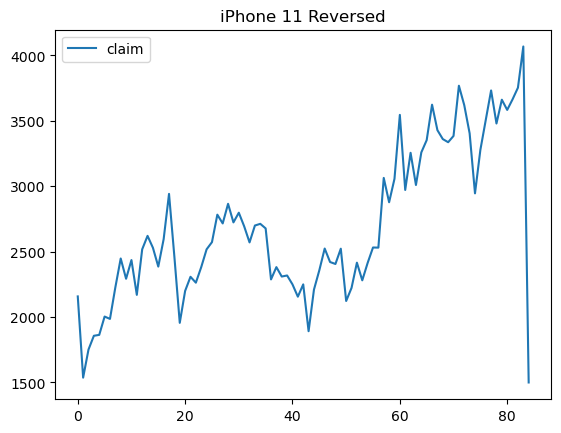

In [7]:
reverse_iphone_11 = result_iphone_11_copy.iloc[::-1].reset_index(drop=True)

display(reverse_iphone_11)

reverse_iphone_11.plot()
plt.title("iPhone 11 Reversed")

In [8]:
train_11 = reverse_iphone_11['claim']

arima_model_11 = pm.auto_arima(train_11,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5, max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5, max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True, stepwise=True,
          random_state=20, n_fits=50)

arima_model_11.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1083.892, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1079.304, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1075.127, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1078.088, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1076.605, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1075.973, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1078.381, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1077.763, Time=0.28 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1080.195, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1076.974, Time=0.14 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1076.915, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1076.139, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1078.772, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1076.328, Time=0.20 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -534.564
Date:                            Tue, 11 Apr 2023   AIC                           1075.127
Time:                                    23:11:44   BIC                           1081.957
Sample:                                         0   HQIC                          1077.846
                                             - 85                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4659      0.256     -1.819      0.069      -0.968       0.036
ma.S.L12      -0.5498      0.316     -1.739      0.082      -1.169       0.070
sigma2      1.572e+05   9048.554     17.375      0.000    1.39e+05    1.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1457.57
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                            -3.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,predicted_values
85,2464.953791
86,2278.975238
87,2377.254561
88,2575.012227
89,2680.468406
...,...
164,1221.359750
165,1341.560055
166,1382.671755
167,1632.263421


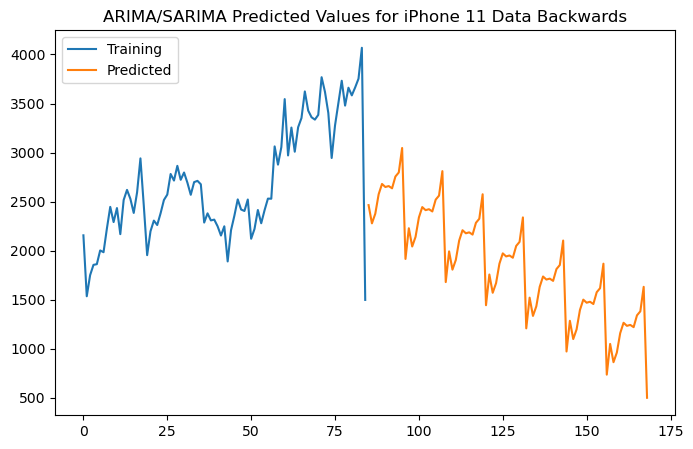

In [9]:
prediction_11 = pd.DataFrame(arima_model_11.predict(n_periods = 84))
prediction_11.columns = ['predicted_values']

display(prediction_11)

plt.figure(figsize=(8,5))
plt.plot(train_11,label="Training")
plt.plot(prediction_11,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA/SARIMA Predicted Values for iPhone 11 Data Backwards")
plt.show()

# iPhone 11 release was September 20, 2019, and we can assume that it is reasonable that it can take a month before the first
# week of phone claims starts
# Row 84 represents 6/28/2021 data values and we are able to forecasted backwards to Monday, November 18, 2019
# Due to the model prediction, it does not make sense to further roll the data back due to the spike and limitiation with iPhone
# 11's true release date. The lowest value is about 501 iPhone 11 claims on index 168

In [10]:
revised_11 = pd.DataFrame(train_11)
revised_11.columns = ['claim']

reordered_prediction_11 = prediction_11.reset_index(drop=True).rename(columns={'predicted_values': 'claim'})

reordered_prediction_11['claim'] = reordered_prediction_11['claim'].round(decimals = 0)


frames = [revised_11, reordered_prediction_11]
iphone_11_final = pd.concat(frames).reset_index(drop=True)

iphone_11_final

,claim
0,2157.0
1,1536.0
2,1751.0
3,1856.0
4,1863.0
...,...
164,1221.0
165,1342.0
166,1383.0
167,1632.0


,claim
0,2157.0
1,1536.0
2,1751.0
3,1856.0
4,1863.0
...,...
164,1221.0
165,1342.0
166,1383.0
167,1632.0


<AxesSubplot:>

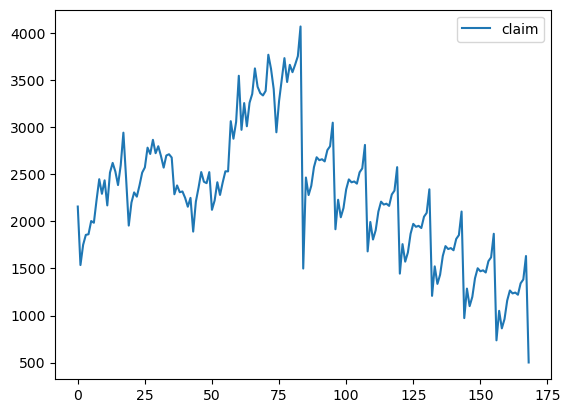

In [11]:
display(iphone_11_final)
iphone_11_final.plot()

## iPhone 12 Preparation

,weeks_monday,claim
0,2023-02-06,4604
1,2023-01-30,3764
2,2023-01-23,4136
3,2023-01-16,4277
4,2023-01-09,3959
...,...,...
80,2021-07-26,1157
81,2021-07-19,1144
82,2021-07-12,1045
83,2021-07-05,1017


Text(0.5, 1.0, 'iPhone 12 Reversed')

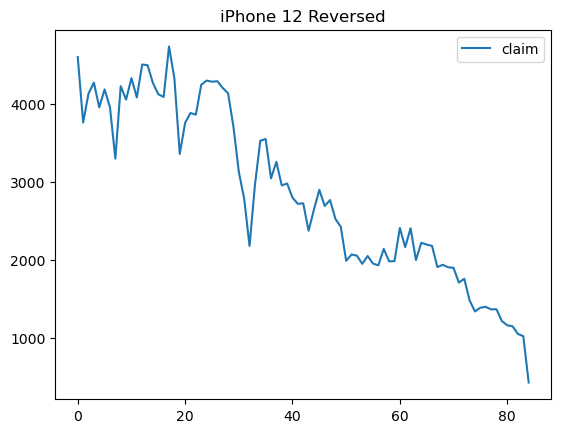

In [12]:
reverse_iphone_12 = result_iphone_12_copy.iloc[::-1].reset_index(drop=True)

display(reverse_iphone_12)

reverse_iphone_12.plot()
plt.title("iPhone 12 Reversed")

In [13]:
train_12 = reverse_iphone_12['claim']

arima_model_12 = pm.auto_arima(train_12,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5, max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5, max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True, stepwise=True,
          random_state=20, n_fits=50)

arima_model_12.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1068.934, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1058.397, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1050.470, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1062.588, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1051.448, Time=0.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1051.059, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1057.082, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1052.756, Time=0.56 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1052.274, Time=0.14 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1052.422, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1051.426, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1053.643, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1051.349, Time=0.19 sec

Best model:  ARIMA(0,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -522.235
Date:                            Tue, 11 Apr 2023   AIC                           1050.470
Time:                                    23:11:57   BIC                           1057.300
Sample:                                         0   HQIC                          1053.189
                                             - 85                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3765      0.125     -3.022      0.003      -0.621      -0.132
ma.S.L12      -0.6221      0.148     -4.194      0.000      -0.913      -0.331
sigma2      1.081e+05    1.6e+04      6.735      0.000    7.66e+04     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.87
Prob(Q):                              1.00   Prob(JB):                         0.14
Heteroskedasticity (H):               0.27   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,predicted_values
85,493.555727
86,407.253254
87,336.486425
88,357.196190
89,325.776788
90,275.733312
91,20.443539
92,40.972591
93,131.452240
94,92.554651


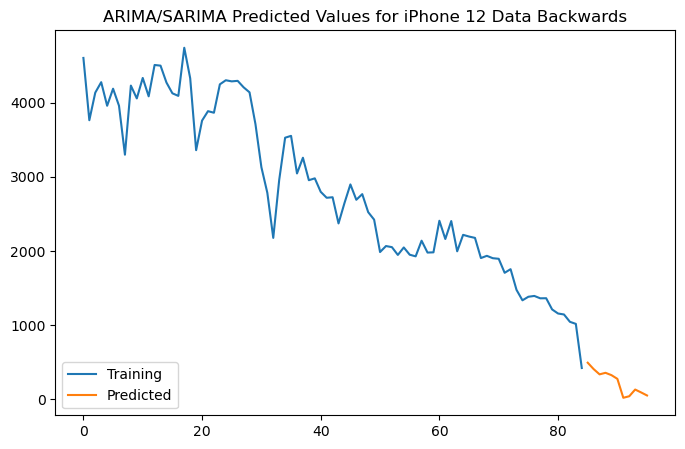

In [15]:
prediction_12 = pd.DataFrame(arima_model_12.predict(n_periods = 11))
prediction_12.columns = ['predicted_values']
display(prediction_12)


plt.figure(figsize=(8,5))
plt.plot(train_12,label="Training")
plt.plot(prediction_12,label="Predicted")
plt.legend(loc = 'lower left')
plt.title("ARIMA/SARIMA Predicted Values for iPhone 12 Data Backwards")
plt.show()

# iPhone 12 release was October 23, 2020, and we assume that it is reasonable that it takes at least a month for the first week
# of iphone claims to start
# Forecasted the data back to around Monday, April 12, 2021 as it became unreasonable to go further as the iPhone 12 claims
# became negative. Thus, I was only able to roll it back by 11 weeks before June 28, 2021
# Current lowest value is about 51 on index 95

In [16]:
revised_12 = pd.DataFrame(train_12)
revised_12.columns = ['claim']

revised_12 = revised_12.iloc[::-1].reset_index(drop=True)

display(revised_12)


reordered_prediction_12 = prediction_12.iloc[::-1].reset_index(drop=True).rename(columns={'predicted_values': 'claim'})

reordered_prediction_12['claim'] = reordered_prediction_12['claim'].round(decimals = 0)

frames = [iphone_11_final, reordered_prediction_12, revised_12]

iphone_12_final = pd.concat(frames).reset_index(drop=True)

iphone_12_final

,claim
0,422
1,1017
2,1045
3,1144
4,1157
...,...
80,3959
81,4277
82,4136
83,3764


,claim
0,2157.0
1,1536.0
2,1751.0
3,1856.0
4,1863.0
...,...
260,3959.0
261,4277.0
262,4136.0
263,3764.0


<AxesSubplot:>

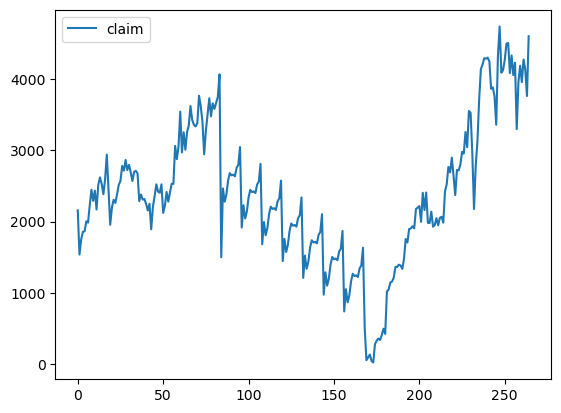

In [17]:
# Plot Includes iPhone 11 and 12 cycles together
iphone_12_final.plot()

# iPhone 13 Prepartion

,weeks_monday,claim
0,2023-02-06,4270
1,2023-01-30,3740
2,2023-01-23,4090
3,2023-01-16,3828
4,2023-01-09,3616
...,...,...
60,2021-12-13,10
61,2021-12-06,2
62,2021-11-29,6
63,2021-11-22,3


Text(0.5, 1.0, 'iPhone 13 Reversed')

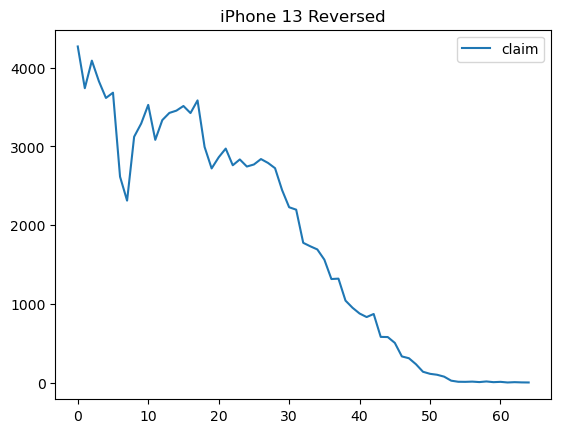

In [18]:
reverse_iphone_13 = result_iphone_13_copy.iloc[::-1].reset_index(drop=True)

display(reverse_iphone_13)

reverse_iphone_13.plot()
plt.title("iPhone 13 Reversed")

In [19]:
reverse_iphone_13_WIP = reverse_iphone_13.reset_index(drop=True).drop(['weeks_monday'], axis=1)

reverse_iphone_13_WIP = reverse_iphone_13_WIP #* 1.05

display(iphone_12_final)
frames12_13 = [iphone_12_final, reverse_iphone_13_WIP]


iphone_13_combined_final = pd.concat(frames12_13).reset_index(drop=True)

# Appending iPhone 13 to the iPhone 11 & 12 product life cycles
iphone_13_combined_final

,claim
0,2157.0
1,1536.0
2,1751.0
3,1856.0
4,1863.0
...,...
260,3959.0
261,4277.0
262,4136.0
263,3764.0


,claim
0,2157.0
1,1536.0
2,1751.0
3,1856.0
4,1863.0
...,...
325,10.0
326,2.0
327,6.0
328,3.0


## iPhone 14 Combined Dataset

In [20]:
result_iphone_14

,weeks_monday,claim
0,2022-11-14,9
1,2022-11-21,30
2,2022-11-28,23
3,2022-12-05,43
4,2022-12-12,32
5,2022-12-19,36
6,2022-12-26,44
7,2023-01-02,45
8,2023-01-09,59
9,2023-01-16,60


In [21]:
result_iphone_14_WIP = result_iphone_14.reset_index(drop=True).drop(['weeks_monday'], axis=1)

frames13_14 = [iphone_13_combined_final, result_iphone_14_WIP]

iphone_14_combined_final = pd.concat(frames13_14).reset_index(drop=True)

# iphone_14_combined_final represents the final combined dataset of all iPhone 11-14 through cyclical product cycle
iphone_14_combined_final

,claim
0,2157.0
1,1536.0
2,1751.0
3,1856.0
4,1863.0
...,...
338,59.0
339,60.0
340,57.0
341,54.0


In [22]:
# Using the last 4 values of iPhone 14 as the test dataset, the rest is the training data
df_train = iphone_14_combined_final[:339]
df_test = iphone_14_combined_final[-4:]


In [23]:
arima_model = pm.auto_arima(df_train,start_p=0,d=0,start_q=0,
          max_p=5,max_d=5, max_q=5, start_P=0,
          D=0, start_Q=0, max_P=5, max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True, stepwise=True,
          random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5743.443, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4830.207, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5229.807, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6264.020, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4889.443, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=4826.781, Time=0.99 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=4826.759, Time=1.67 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=4826.227, Time=4.91 sec
 ARIMA(1,0,0)(5,0,0)[12] intercept   : AIC=4828.260, Time=7.28 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=4828.106, Time=4.70 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=4828.666, Time=2.49 sec
 ARIMA(1,0,0)(5,0,1)[12] intercept   : AIC=4828.894, Time=7.85 sec
 ARIMA(0,0,0)(4,0,0)[12] intercept   : AIC=inf, Time=4.08 sec
 ARIMA(2,0,0)(4,0,0)[12] intercept   : AIC=4807.795, Time=5.07 sec
 ARIMA(2,0,0)(3,0,0)[12]

In [24]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 10))
prediction.columns = ['predicted_values']

prediction = prediction.round(0)

prediction

,predicted_values
339,90.0
340,113.0
341,134.0
342,140.0
343,161.0
344,171.0
345,173.0
346,189.0
347,205.0
348,222.0


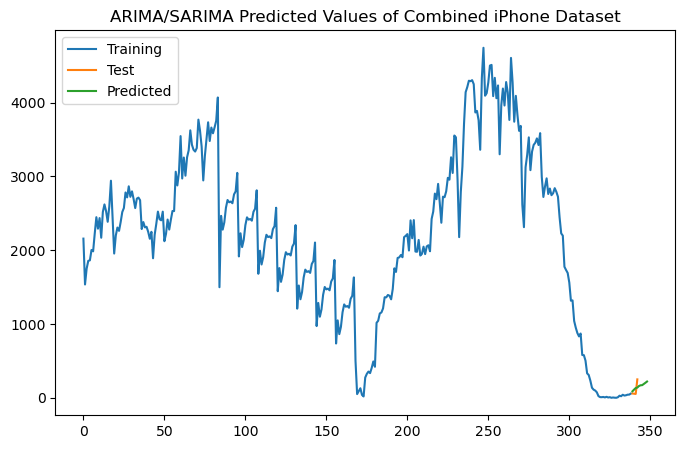

In [26]:
# This graphic represents the iPhone 11-14 product lifecyles appended together in the proper reverse and forward product life
# cycles and with the iPhone 14 prediction values
plt.figure(figsize=(8,5))
plt.plot(df_train,label="Training")
plt.plot(df_test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA/SARIMA Predicted Values of Combined iPhone Dataset")
plt.show()

In [25]:
score = np.sqrt(mean_squared_error(df_test, prediction[0:4]))

print(f' RMSE Score on Test set: {score:0.2f}')

display(df_test)
display(prediction)

 RMSE Score on Test set: 75.43


,claim
339,60.0
340,57.0
341,54.0
342,251.0


,predicted_values
339,90.0
340,113.0
341,134.0
342,140.0
343,161.0
344,171.0
345,173.0
346,189.0
347,205.0
348,222.0


In [27]:
# Rows 345-348 are the iPhone 14 prediction values for March 2023
calculation = prediction[0:4]

WMAPE_frames = [df_test, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

# WMPAE value is 65.6398% 
WMAPE

65.63981042654028